

```
Credit Scoring and Loans 💸


## Project Overview

Banks use credit scoring algorithms to estimate the probability of default when deciding whether a loan should be granted. In this project, your task is to build a credit scoring algorithm that predicts the probability of financial distress within the next two years.

The goal of this project is to create a model that loan providers can use to help borrowers make informed financial decisions.

---

## Files Provided

You can download the following `.csv` files from Blackboard:

- **`train.csv`**: Training data that you can use to train your algorithms.
- **`test.csv`**: Test data for which you will make predictions.
- **`submission.csv`**: An example of the structure of the final `.csv` file that you’ll need to upload as part of your final submission.



```



In [ ]:
# Download the modules needed

!pip install -U scikit-learn
!pip install catboost
!pip install xgboost
!pip install tqdm
! pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.3 MB/s eta 0:00:00


In [ ]:
# Import all the tools we need
import xgboost as xgb

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# we want our plots to appear inside the notebook
%matplotlib inline
# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")


In [ ]:
train_data.head(). # I see here that there is an unamed column! to be fixed

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.0,0.034949,59.0,0.0,0.004933,7959.688894,5.0,0.0,0.0,0.0,0.0
1,1,0.0,0.155308,47.0,0.0,881.000000,NaN,6.0,0.0,1.0,0.0,0.0
2,2,0.0,0.165166,62.0,1.0,0.020327,2851.722407,8.0,0.0,0.0,0.0,0.0
3,3,0.0,0.010886,61.0,0.0,0.642979,1115.657341,6.0,0.0,1.0,0.0,0.0
4,4,0.0,0.000717,49.0,0.0,3603.000000,NaN,15.0,0.0,3.0,0.0,0.0


In [ ]:
train_data = train_data.rename(columns={'Unnamed: 0': 'id'})

In [ ]:
test_data = test_data.rename(columns={'Unnamed: 0': 'id'})

# Data Vizualisation

In [ ]:
# Count missing values in each column
missing_values = train_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

,0
MonthlyIncome,22187
NumberOfDependents,2945


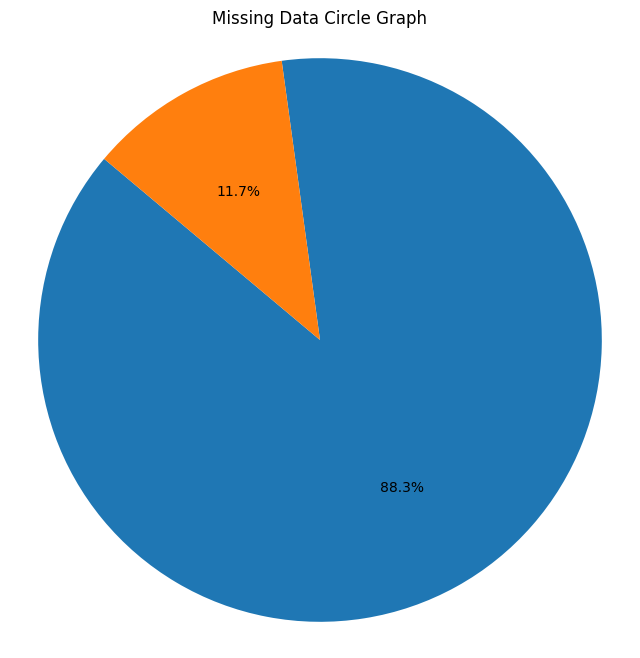

In [ ]:

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(missing_values, autopct='%1.1f%%', startangle=140)
plt.title('Missing Data Circle Graph')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# we see from output that 11.7 % of the data is null

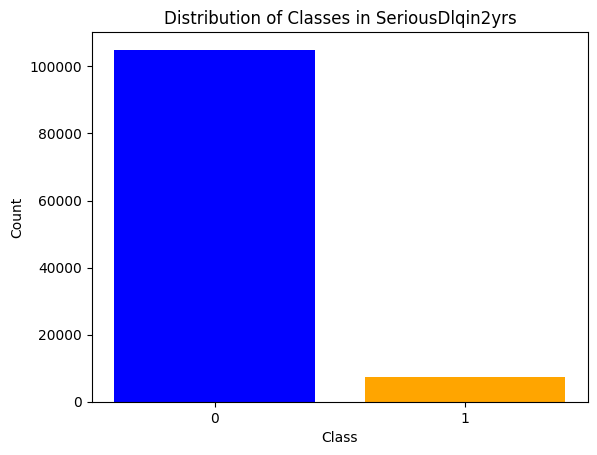

In [ ]:
# Count the occurrences of each class
class_counts = train_data["SeriousDlqin2yrs"].value_counts()

# Plotting
plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
plt.title('Distribution of Classes in SeriousDlqin2yrs')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(class_counts.index, ['0', '1'])
plt.show()

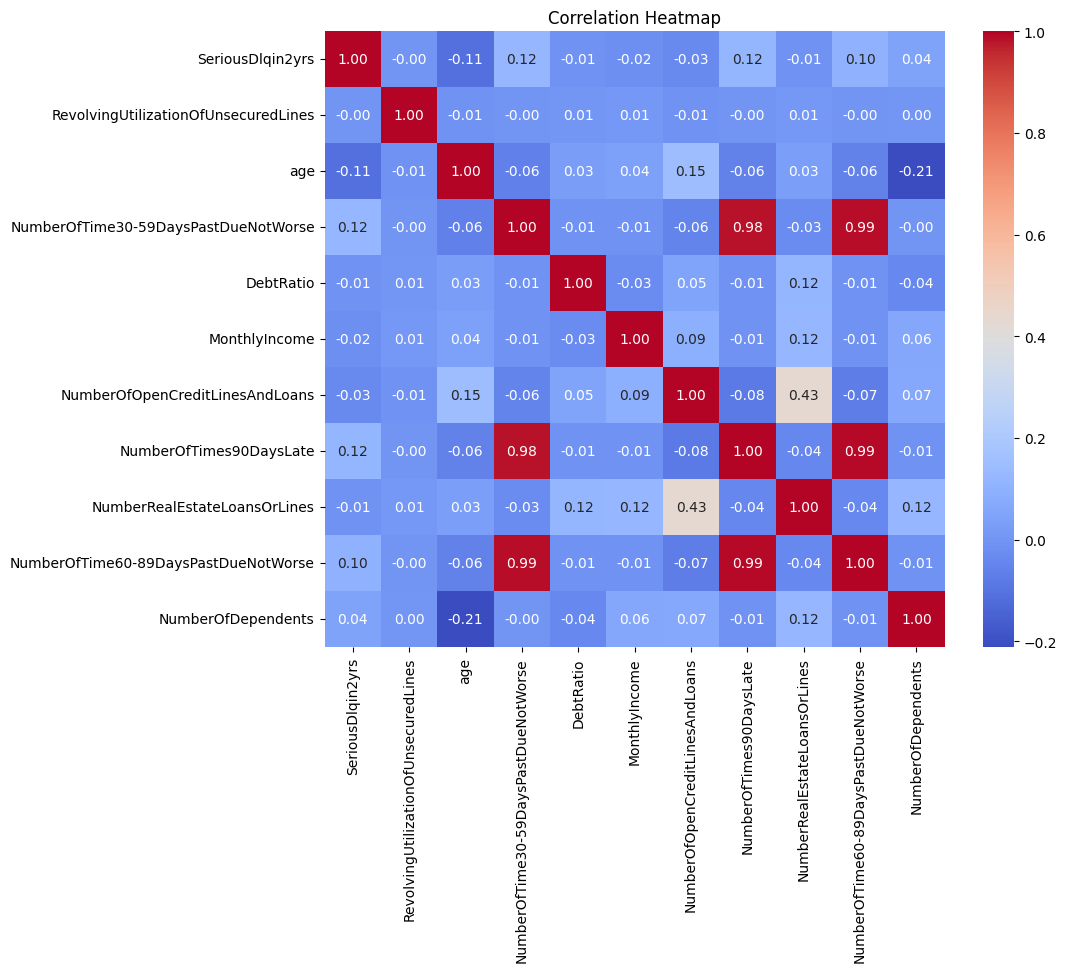

In [ ]:
import seaborn as sns

# Increase the size of the heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap with larger font size for annotations
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})

plt.title('Correlation Heatmap')
plt.show()


## Data cleaning

In [ ]:
colonnes_avec_nan = train_data.columns[train_data.isna().any()].tolist()

In [ ]:
colonnes_avec_nan

['MonthlyIncome', 'NumberOfDependents']

In [ ]:
median = train_data['MonthlyIncome'].median()
train_data['MonthlyIncome'] = train_data['MonthlyIncome'].fillna(median)

In [ ]:
median = train_data['NumberOfDependents'].median()
train_data['NumberOfDependents'] = train_data['NumberOfDependents'].fillna(median)

In [ ]:
colonnes_avec_nan = train_data.columns[train_data.isna().any()].tolist()
colonnes_avec_nan  # no columns with null values anymore

[]

In [ ]:
colonnes_avec_nan = test_data.columns[test_data.isna().any()].tolist()

In [ ]:
colonnes_avec_nan

['MonthlyIncome', 'NumberOfDependents']

In [ ]:
median = test_data['MonthlyIncome'].median()
test_data['MonthlyIncome'] = test_data['MonthlyIncome'].fillna(median)

In [ ]:
median = test_data['NumberOfDependents'].median()
test_data['NumberOfDependents'] = test_data['NumberOfDependents'].fillna(median)

In [ ]:
colonnes_avec_nan = test_data.columns[test_data.isna().any()].tolist()
colonnes_avec_nan

[]

# Data for training

In [ ]:
y = train_data["SeriousDlqin2yrs"]
y.unique(). # Binary variable

array([0., 1.])

In [ ]:
X = train_data.drop("SeriousDlqin2yrs",axis=1)

In [ ]:
X = X.rename(columns={'Unnamed: 0': 'id'})

## Training the model without using any technique

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import numpy as np
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "GBM": xgb.XGBClassifier(),
    "SVM": SVC(),
    "Decision Trees": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier(),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": CatBoostClassifier()
}

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    # Set random seed
    np.random.seed(42)
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and print its classification report
        y_pred = model.predict(X_test)
        print(confusion_matrix(y_test, y_pred))
        print(f"Classification Report for {name}:")
        print(classification_report(y_test, y_pred))
        print("="*60)  # Separator for better readability

In [ ]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [ ]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[20996    30]
 [ 1457    17]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     21026
         1.0       0.36      0.01      0.02      1474

    accuracy                           0.93     22500
   macro avg       0.65      0.51      0.49     22500
weighted avg       0.90      0.93      0.90     22500

[[20960    66]
 [ 1457    17]]
Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.96     21026
         1.0       0.20      0.01      0.02      1474

    accuracy                           0.93     22500
   macro avg       0.57      0.50      0.49     22500
weighted avg       0.89      0.93      0.90     22500

[[20790   236]
 [ 1206   268]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     21026
         1.0       0.53  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[[19816  1210]
 [ 1069   405]]
Classification Report for Decision Trees:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95     21026
         1.0       0.25      0.27      0.26      1474

    accuracy                           0.90     22500
   macro avg       0.60      0.61      0.60     22500
weighted avg       0.90      0.90      0.90     22500

[[20760   266]
 [ 1199   275]]
Classification Report for XGBoost:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     21026
         1.0       0.51      0.19      0.27      1474

    accuracy                           0.93     22500
   macro avg       0.73      0.59      0.62     22500
weighted avg       0.92      0.93      0.92     22500

[LightGBM] [Info] Number of positive: 6046, number of negative: 83954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011652 seconds.
You can set `force_col_wise=true`

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from lightgbm import LGBMClassifier

# Define the scorer for precision on class 1
scorer = make_scorer(precision_score, pos_label=1)

# Define the model
lgbm_model = LGBMClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'num_leaves': [20, 30, 40],
}

# Perform GridSearchCV with precision scoring
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Get the best model and its precision for class 1
best_model = grid_search.best_estimator_
best_precision = grid_search.best_score_

# Report the best precision for class 1
print("Best Precision for class 1:", best_precision)

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Display the classification report
from sklearn.metrics import classification_report
print("Classification Report for LightGBM:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`.

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4836, number of negative: 67164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067167 -> initscore=-2.631049
[LightGBM] [Info] Start training from score -2.631049


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_ta

[LightGBM] [Info] Number of positive: 4837, number of negative: 67163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 72000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067181 -> initscore=-2.630828
[LightGBM] [Info] Start training from score -2.630828


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6046, number of negative: 83954
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067178 -> initscore=-2.630872
[LightGBM] [Info] Start training from score -2.630872
Best Precision for class 1: 0.6817964250313666
Classification Report for LightGBM:
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     21026
         1.0       0.62      0.08      0.13      1474

    accuracy                           0.94     22500
   macro avg       0.78      0.54      0.55     22500
weighted avg       0.92      0.94      0.91     22500



In [ ]:
# Separate IDs from features
test_ids = test_data['id']
test_features = test_data.drop(columns=['id'])

# Predict probabilities using the trained model
predicted_probabilities = best_model.predict_proba(test_features)

# Create DataFrame with IDs and predicted probabilities
results_df = pd.DataFrame({
    'id': test_ids,
    'probability_0': predicted_probabilities[:, 0],  # Probability of target 0
    'probability_1': predicted_probabilities[:, 1]   # Probability of target 1
})
# Save filtered DataFrame to CSV
results_df.to_csv('predictions_normale.csv', index=False)

In [ ]:
results_df

,id,probability_0,probability_1
0,0,0.937199,0.062801
1,1,0.970930,0.029070
2,2,0.949809,0.050191
3,3,0.983361,0.016639
4,4,0.983054,0.016946
...,...,...,...
37495,37495,0.833702,0.166298
37496,37496,0.979920,0.020080
37497,37497,0.956537,0.043463
37498,37498,0.979277,0.020723


## Applying Techniques to Solve Imbalanced Classes

# Random under Sampling thechnique

In [ ]:
# class count
class_count_0, class_count_1 = train_data['SeriousDlqin2yrs'].value_counts()

# Separate class
class_0 = train_data[train_data['SeriousDlqin2yrs'] == 0]
class_1 = train_data[train_data['SeriousDlqin2yrs'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (104980, 11)
class 1: (7520, 11)


total class of 1 and0: SeriousDlqin2yrs
0.0    7520
1.0    7520
Name: count, dtype: int64


<Axes: title={'center': 'count (target)'}, xlabel='SeriousDlqin2yrs'>

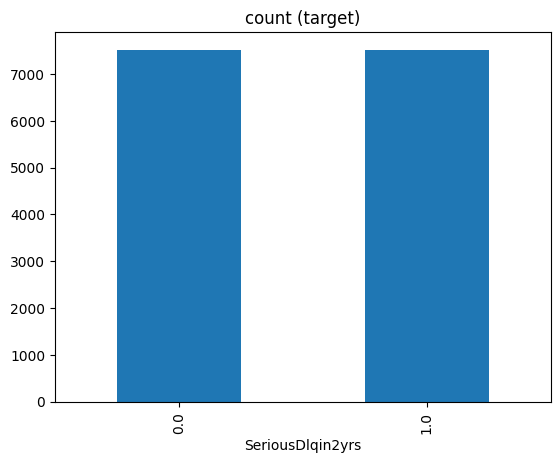

In [ ]:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",test_under['SeriousDlqin2yrs'].value_counts())# plot the count after under-sampeling
test_under['SeriousDlqin2yrs'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(test_under.drop("SeriousDlqin2yrs",axis=1),
                                                    test_under["SeriousDlqin2yrs"],
                                                    test_size=0.2)

In [ ]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[1344  180]
 [ 604  880]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.69      0.88      0.77      1524
         1.0       0.83      0.59      0.69      1484

    accuracy                           0.74      3008
   macro avg       0.76      0.74      0.73      3008
weighted avg       0.76      0.74      0.73      3008

[[860 664]
 [624 860]]
Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       0.58      0.56      0.57      1524
         1.0       0.56      0.58      0.57      1484

    accuracy                           0.57      3008
   macro avg       0.57      0.57      0.57      3008
weighted avg       0.57      0.57      0.57      3008

[[1200  324]
 [ 336 1148]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78      1524
         1.0       0.78      0.77      0.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'depth': [4, 6, 8],
}
scorer = make_scorer(precision_score, pos_label=1)

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_precision = grid_search.best_score_

print("best precision for the classe 1 :", best_precision)

y_pred = best_model.predict(X_test)


from sklearn.metrics import classification_report
print("Repport of classification for CatBoostClassifier :")
print(classification_report(y_test, y_pred))


Streaming output truncated to the last 5000 lines.
111:	learn: 0.4164882	total: 665ms	remaining: 523ms
112:	learn: 0.4162366	total: 671ms	remaining: 516ms
113:	learn: 0.4161316	total: 676ms	remaining: 510ms
114:	learn: 0.4159746	total: 681ms	remaining: 503ms
115:	learn: 0.4157386	total: 690ms	remaining: 499ms
116:	learn: 0.4155400	total: 696ms	remaining: 494ms
117:	learn: 0.4151026	total: 701ms	remaining: 487ms
118:	learn: 0.4145739	total: 706ms	remaining: 481ms
119:	learn: 0.4145666	total: 709ms	remaining: 472ms
120:	learn: 0.4144806	total: 714ms	remaining: 466ms
121:	learn: 0.4137168	total: 719ms	remaining: 460ms
122:	learn: 0.4133504	total: 725ms	remaining: 454ms
123:	learn: 0.4130152	total: 733ms	remaining: 449ms
124:	learn: 0.4128158	total: 741ms	remaining: 444ms
125:	learn: 0.4122697	total: 746ms	remaining: 438ms
126:	learn: 0.4117836	total: 752ms	remaining: 432ms
127:	learn: 0.4117024	total: 758ms	remaining: 426ms
128:	learn: 0.4115570	total: 763ms	remaining: 420ms
129:	learn: 0

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score
from catboost import CatBoostClassifier
catboost_model = CatBoostClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'depth': [4, 6, 8],  # Profondeur de l'arbre
}

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_precision = grid_search.best_score_

print("Best precision for the classe 1 :", best_precision)

y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report
print("Rapport of classification for CatBoostClassifier :")
print(classification_report(y_test, y_pred))


Streaming output truncated to the last 5000 lines.
111:	learn: 0.4164882	total: 670ms	remaining: 526ms
112:	learn: 0.4162366	total: 675ms	remaining: 520ms
113:	learn: 0.4161316	total: 681ms	remaining: 514ms
114:	learn: 0.4159746	total: 686ms	remaining: 507ms
115:	learn: 0.4157386	total: 692ms	remaining: 501ms
116:	learn: 0.4155400	total: 697ms	remaining: 494ms
117:	learn: 0.4151026	total: 702ms	remaining: 488ms
118:	learn: 0.4145739	total: 708ms	remaining: 482ms
119:	learn: 0.4145666	total: 710ms	remaining: 473ms
120:	learn: 0.4144806	total: 715ms	remaining: 467ms
121:	learn: 0.4137168	total: 721ms	remaining: 461ms
122:	learn: 0.4133504	total: 726ms	remaining: 455ms
123:	learn: 0.4130152	total: 732ms	remaining: 448ms
124:	learn: 0.4128158	total: 737ms	remaining: 442ms
125:	learn: 0.4122697	total: 742ms	remaining: 436ms
126:	learn: 0.4117836	total: 748ms	remaining: 430ms
127:	learn: 0.4117024	total: 753ms	remaining: 424ms
128:	learn: 0.4115570	total: 758ms	remaining: 417ms
129:	learn: 0

In [ ]:
# Separate IDs from features
test_ids = test_data['id']
test_features = test_data.drop(columns=['id'])

# Predict probabilities using the trained model
predicted_probabilities = best_model.predict_proba(test_features)

# Create DataFrame with IDs and predicted probabilities
results_df = pd.DataFrame({
    'id': test_ids,
    'probability_0': predicted_probabilities[:, 0],  # Probability of target 0
    'probability_1': predicted_probabilities[:, 1]   # Probability of target 1
})
# Save filtered DataFrame to CSV
results_df.to_csv('predictions_Random-under-Sampling.csv', index=False)

# Random Over-Sampling

total class of 1 and 0: SeriousDlqin2yrs
0.0    7520
1.0    7520
Name: count, dtype: int64


<Axes: title={'center': 'count (target)'}, xlabel='SeriousDlqin2yrs'>

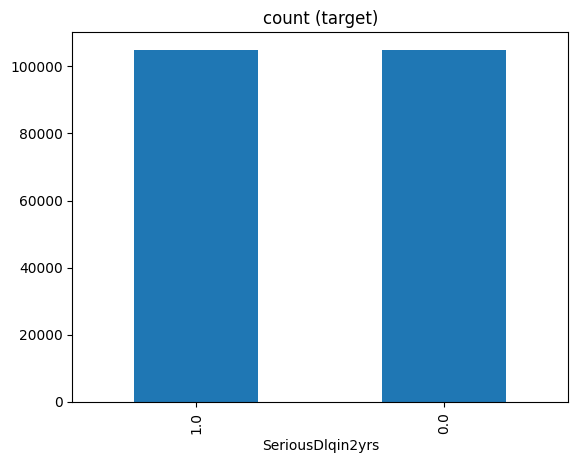

In [ ]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:",test_under['SeriousDlqin2yrs'].value_counts())
test_over['SeriousDlqin2yrs'].value_counts().plot(kind='bar', title='count (target)')

In [ ]:
# Split data into train and test sets
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(test_over.drop("SeriousDlqin2yrs",axis=1),
                                                    test_over["SeriousDlqin2yrs"],
                                                    test_size=0.2)

In [ ]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[18728  2286]
 [ 9196 11782]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.67      0.89      0.77     21014
         1.0       0.84      0.56      0.67     20978

    accuracy                           0.73     41992
   macro avg       0.75      0.73      0.72     41992
weighted avg       0.75      0.73      0.72     41992

[[17356  3658]
 [   13 20965]]
Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90     21014
         1.0       0.85      1.00      0.92     20978

    accuracy                           0.91     41992
   macro avg       0.93      0.91      0.91     41992
weighted avg       0.93      0.91      0.91     41992

[[20427   587]
 [    0 20978]]
Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     21014
         1.0       0.97  

In [ ]:
# Initialize Random Forest classifier. ( THE ONE with the highest accuracy)
rf_classifier = RandomForestClassifier()

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


In [ ]:
# Separate IDs from features
test_ids = test_data['id']
test_features = test_data.drop(columns=['id'])

# Predict probabilities using the trained model
predicted_probabilities = rf_classifier.predict_proba(test_features)

# Create DataFrame with IDs and predicted probabilities
results_df = pd.DataFrame({
    'id': test_ids,
    'probability_0': predicted_probabilities[:, 0],  # Probability of target 0
    'probability_1': predicted_probabilities[:, 1]   # Probability of target 1
})
# Save filtered DataFrame to CSV
results_df.to_csv('predictions_Random-Over-Sampling.csv', index=False)



# Conclusion

This project aimed to develop a credit scoring model to predict the probability of financial distress within the next two years. Through experimentation with various machine learning models and techniques to address imbalanced datasets, we achieved significant insights and promising results.

We evaluated models like Logistic Regression, K-Nearest Neighbors, Random Forest, CatBoost, and others. While CatBoost demonstrated high precision, especially when combined with Random Under-Sampling, it was observed that Random Forest, with its inherent ability to handle imbalanced datasets, yielded the highest overall accuracy. This highlights the importance of considering both precision and accuracy when evaluating model performance for imbalanced classification problems.

The Random Under-Sampling technique proved effective in creating a balanced dataset, leading to improved model performance for CatBoost. Random Over-Sampling also showed potential, indicating that various sampling techniques can be valuable in mitigating class imbalance issues.

The final Random Forest model provides a robust tool for loan providers to assess credit risk with improved accuracy. This enables borrowers to make well-informed financial decisions, contributing to a more stable financial environment.

Future work could explore more advanced techniques to address imbalanced classes, such as SMOTE or ensemble methods. Additionally, incorporating further relevant features and experimenting with different model hyperparameters could potentially enhance the model's predictive capabilities.

In conclusion, this project demonstrates the effectiveness of machine learning in credit scoring, showcasing how Random Forest can be leveraged to predict financial distress with high accuracy. This paves the way for improved risk management and informed decision-making in the lending industry.